# Claiming forest carbon
This notebook reads, transforms, and plots selected elements of the look-up tables from [Schedule 6 of the Climate Change (Forestry Sector) Regulations 2008](https://www.legislation.govt.nz/regulation/public/2008/0355/latest/DLM1633733.html).

## Look-up tables
The look-up tables are stored as four separate files in CSV format, e.g. ``./tables-data/table1.csv``, which where fetched from the official website using a script ``./tables-data/fetch.py``. 

These tables contain pre-calculated values for the *cumulative* carbon stock $S_a^T$ measured in tonnes per hectare of a given forest type $T$ and age $a=0,1,\dots,a^{\rm max}_{T}$ (in years), where $a^{\rm max}_{T} = 35$ for $T =$ "Exotic hardwoods" and $a^{\rm max}_{T} = 50$ for all other supported forest types.

Annual carbon stock *change* $s_a^T$ can be calculated using the following formula:

$$
s_a^T = \left\{
\begin{array}{lcl}
0 & \mathrm{for} & a = 0, \\
S_a^T - S_{a-1}^T & \mathrm{for} & a = 1,\dots, a^{\rm max}_{T}.
\end{array} \right.
$$

We now build an interactive plot of $S_{a}^{T}$ and $s_{a}^{T}$ vs $a$ for a given $T$, which can be selected using a drop-down menu.

In [1]:
import pandas as pd             # for handling dataframes
import matplotlib.pyplot as plt # for plotting data
import ipywidgets as widgets    # for interactivity
import numpy as np              # for more advanced numerics

In [2]:
# Function for calculating annual carbon stock change per hectare
def stock_change(y, T, table):
    return round(table[T][y] - table[T][y-1], 1)

# Function for calling stock_change over the entire time span 
def stock_changes(T, table):
    values=[0]
    for y in range(1, len(table)):
        values.append(stock_change(y,T,table))
    return values

In [3]:
# load first two tables as dataframes and merge into one
table = pd.concat([pd.read_csv('./tables-data/table1.csv'),
                   pd.read_csv('./tables-data/table2.csv')], 
                  axis = 1)

# drop both 'Age' columns, since age matches row index
table.drop('Age (yrs)', inplace = True, axis = 1)

# prepend "P.Radiata" to regionalised Pinus Radiata.
subs = {}
for label in table.columns:
    if(len(label.split()) == 1): 
        subs[label]="P.Radiata in "+label
table = table.rename(columns = subs)

# show first few rows of the final table
table.head(10)

,P.Radiata in Ak,P.Radiata in W/T,P.Radiata in BOP,P.Radiata in Gis,P.Radiata in H/SNI,P.Radiata in N/M,P.Radiata in C/W,P.Radiata in O,P.Radiata in S,Douglas fir,Exotic softwoods,Exotic hardwoods,Indigenous forest
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.4,0.4,0.6,0.5,0.2,0.2,0.3,0.2,0.1,0.2,0.1,0.6
2,3.0,3.0,2.0,4.0,3.0,1.0,1.0,2.0,1.0,0.1,1.0,3.0,1.2
3,8.0,7.0,6.0,10.0,9.0,3.0,2.0,5.0,3.0,0.4,3.0,13.0,2.5
4,29.0,25.0,24.0,37.0,34.0,12.0,5.0,9.0,14.0,1.0,12.0,34.0,4.6
5,59.0,50.0,51.0,77.0,71.0,28.0,15.0,26.0,35.0,2.0,26.0,63.0,7.8
6,98.0,84.0,84.0,121.0,113.0,48.0,31.0,49.0,65.0,4.0,45.0,98.0,12.1
7,131.0,111.0,118.0,162.0,155.0,73.0,53.0,72.0,99.0,7.0,63.0,137.0,17.5
8,153.0,130.0,143.0,190.0,185.0,100.0,76.0,94.0,134.0,20.0,77.0,176.0,24.0
9,166.0,142.0,155.0,201.0,197.0,117.0,101.0,124.0,160.0,33.0,87.0,214.0,31.6


In [4]:
# Wrap the plotting in a callable function
def plot_table(T, table):
    
    years = list(range(len(table)))
    stock = list(table[T].values)
    change = stock_changes(T=T,table=table);

    # Instantiate figure for plotting
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    
    axs[0].plot(stock)
    axs[0].set_ylim(0)
    axs[0].set_ylabel("carbon stock \n (tons/ha)")
    
    axs[1].bar(x = years, 
               height = change, 
               width = -1.0, # -ve to align with right edge
               align = 'edge')
    axs[1].set_xlim(years[0],years[-1])
    axs[1].set_xlabel("age (years)")
    axs[1].set_ylabel("annual change \n(tons/ha)")

    plt.show()

# Define widgets for the forest type
T_widget = widgets.Dropdown(options = list(table.columns), 
                            value = 'Indigenous forest', 
                            description = 'forest type')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_table, 
                           T = T_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(Dropdown(description='forest type', index=12, options=('P.Radiata in Ak', 'P.Radiata in …

## Claim reporting

Now we consider a Claim of carbon stock change in a forest over a number of consecutive years. The calculation requires two additional parameters: $a_{0}$ - the forest age at the start of the first reporting year; and $N$ - the total number of reporting years. Note that the two parameters are not independent, since the underlying look-up tables go up to only $a_{T}^{\rm max}$ years. That is, not only does the calculation require $a_{0} < a_{T}^{\rm max}$, but also $N \leq a_{T}^{\rm max} - a_{0}$, so the range of validity for $N$ depends on the value of $a_{0}$.

We now build an interactive plot of the carbon stock change $s_{a_y}^{T}$ vs reporting years $y=1,\dots,N$, allowing the user to adjust $T$, $a_{0}$, and $N$. The total carbon claim, i.e. $\sum_{y=1}^{N}s_{a_{y}}^{T}$, will be printed in the plot title.

In [5]:
# Function for calling stock_change over a time window 
def claim_years(N, a0, T, table):
    
    values=[]
    
    for y in range(a0+1, a0+N+1):
        values.append(stock_change(y,T,table))
    
    return values

In [6]:
# Define the plotting as a callable function
def plot_claim(N, a0, T, table):
    
    domain = list(range(1,N+1))
    values = claim_years(N = N, a0 = a0, T = T, table = table)
    
    # Instantiate figure for plotting
    fig = plt.figure()
    plt.bar(x = domain, 
            height = values, 
            width = 0.75, # -ve to align with right edge
            align = 'center')
    plt.xlim(domain[0]-0.5,domain[-1]+0.5)
    plt.xlabel("reporting year")
    plt.ylabel("annual claim (tons/ha)")
    plt.title('Total carbon claimed: '
              +str(round(sum(values),1))+
              ' tons / ha', fontsize=16)
    plt.show()

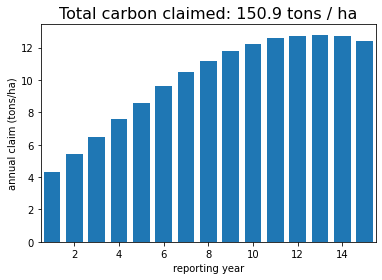

In [7]:
# Show a static example plot
plot_claim(N = 15, 
           a0 = 5, 
           T = 'Indigenous forest', 
           table = table)

In [8]:
# Define widgets for the three parameters
T_widget = widgets.Dropdown(options = list(table.columns[1:]), 
                            value = 'Indigenous forest', 
                            description='$T$')

a0_widget = widgets.IntSlider(value = 0,
                              min = 0,
                              max = 49,
                              description = '$a_{0}$')

N_widget = widgets.IntSlider(value=10, 
                             min=1, 
                             max=50, 
                             description='$N$')

# Special treatment for "Exotic hardwoods"
def update_a0_range(*args):
    if(T_widget.value == 'Exotic hardwoods'):
        a0_widget.max = 35
    else:
        a0_widget.max = 50

T_widget.observe(update_a0_range, 'value')

# Dynamically update the range of validity of N_widget
def update_N_range(*args):
    N_widget.max = a0_widget.max - a0_widget.value

a0_widget.observe(update_N_range, 'value')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_claim, 
                           T = T_widget, 
                           a0 = a0_widget, 
                           N = N_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(IntSlider(value=10, description='$N$', max=50, min=1), IntSlider(value=0, description='$…

## Fitting models

Here we attempt to fit a couple of simple models to the data in the look-up tables. Since the data itself was generated using (unspecified) models, our attempts can be thought of as reverse engineering or guesstimating these underlying models. We start with "Indigenous forest", because the data seems smoothest and more amenable to fitting.

### Logistic growth

Logistic growth refers to S-shaped growth in time-dependent quantity $Q(t)$ described by the following formula,

$$
Q(t) = \frac{a}{1 + e^{b(c-t)}},
$$

where $t$ is time and $a,b,c$ are parameters controlling, respectively, the upper limit, the growth rate, and the position of the inflection point along the time axis. Let's explore the effects of these parameters in an interactive plot built below.  

In [9]:
# Define logistic function with the three usual parameters
# and a fourth parameter introduced for vertical ofsetting.
def logistic(t,a=1.0, b=1.0, c=0.0, d=0.0):
    return a/(1.0+np.exp(b*(c-t))) + d

# Define the analytic derivative
def logistic_deriv(t,a=1.0,b=1.0,c=0.0):
    e = np.exp(b*(c-t))
    return a*b*e/(1+e)**2

# Create vectortized versions
vlogistic = np.vectorize(logistic)
vlogistic_deriv = np.vectorize(logistic_deriv)

In [10]:
# Wrap the plotting in a function
def plot_logistic(a,b,c,d):
    
    x=np.linspace(0,50,101,endpoint=True)
    
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    
    axs[0].plot(x,vlogistic(x, a, b, c, d))
    axs[0].set_ylim(0.0)
    axs[0].set_ylabel('quantity Q(t)')
    axs[0].set_title('Logistic growth' )
    
    axs[1].plot(x,vlogistic_deriv(x, a, b, c))
    axs[1].set_ylim(0.0)
    axs[1].set_xlim(0.0,50.0)
    axs[1].set_xlabel('time units ($t$)')
    axs[1].set_ylabel("time derivative Q'(t)")

    plt.show()

In [11]:
# Define some widgets
a_widget = widgets.FloatSlider(value = 310.0, 
                               min = 100.0, 
                               max = 500.0,
                               step = 10.0,
                               description = 'limit ($a$)')

b_widget = widgets.FloatSlider(value = 0.16, 
                               min = 0.0, 
                               max = 1.0,
                               step = 0.02,
                               description='rate ($b$)')

c_widget = widgets.FloatSlider(value = 16.0, 
                               min = 0.0, 
                               max = 100.0, 
                               description = 'offset ($c$)')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_logistic, 
                           a = a_widget, 
                           b = b_widget, 
                           c = c_widget, 
                           d = widgets.fixed(0))

# Show the plot
ifig

interactive(children=(FloatSlider(value=310.0, description='limit ($a$)', max=500.0, min=100.0, step=10.0), Fl…

### Gompertz growth
Work in progress...

## Geospatial mapping

Work in progress, but the idea is to show a map of New Zealand with a pinned geolocation, and outline the relevant region for Pinus Radiata (if relevant).